# Calculate NDVI for a polygon and export statistics to CSV

UPDATE!!!!


**Background** 

**What does this notebook do?** 

**Date** April 2018

**Author** Claire Krause

**Required inputs** A shape file containing the polygon you would like to use for the analysis

In [1]:
%pylab notebook
%load_ext autoreload
%autoreload 2
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import pandas as pd
from datacube.utils import geometry
import fiona
import rasterio.features
import datetime

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

import sys
import os
sys.path.append('../../10_Scripts/')
import DEAPlotting
import DEADataHandling
import BandIndices

Populating the interactive namespace from numpy and matplotlib


In [2]:
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

In [3]:
shape_file = '/g/data/r78/cek156/dea-notebooks/Crop_mapping/NSWFarmPolygon20161703.shp'

In [4]:
with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

## Set up the extraction query

Note that this code currently doesn't apply resampling to the Landsat data, so it is still at 25 m resolution.

In [8]:
querys2 = {'output_crs': 'EPSG:3577',
         'resolution': (-10, 10),
         'geopolygon': geom,
         'time':('2016-03-01', '2017-04-01')
          }
queryls = {'geopolygon': geom,
           'time':('2016-03-01', '2017-04-01')
          }
#'resampling':'nearest' for pq mask

In [6]:
dc = Datacube(app = 'NDVI extraction')

## First, pull in the data from Sentinel 2a, 2b and Landsat

In [9]:
%%time
AllSensors = ['ls5', 'ls7', 'ls8', 's2a', 's2b']
Alldata = dict()

for Sensor in AllSensors:
    if Sensor[0] == 'l':
        Alldata[Sensor], LScrs, LSaffine = DEADataHandling.load_nbarx(dc, Sensor, queryls, product = 'nbar')
    if Sensor[0] == 's':
        prodname = '{0}_ard_granule'.format(Sensor)
        Alldata[Sensor], S2crs, S2affine = DEADataHandling.load_sentinel(dc, prodname, querys2)

Loading ls5_nbar_albers
Failed to load ls5_nbar_albers
Loading ls7_nbar_albers
Loaded ls7_nbar_albers
Generating mask ls7_pq_albers
Loading ls8_nbar_albers
Loaded ls8_nbar_albers
Generating mask ls8_pq_albers
loading s2a_ard_granule
loaded s2a_ard_granule
making mask
loading s2b_ard_granule
did not load s2b_ard_granule


TypeError: 'NoneType' object is not iterable

In [15]:
Alldata

{'ls7': <xarray.Dataset>
 Dimensions:  (time: 26, x: 581, y: 252)
 Coordinates:
   * time     (time) datetime64[ns] 2016-03-07T00:09:39.500000 ...
   * y        (y) float64 -3.367e+06 -3.367e+06 -3.367e+06 -3.367e+06 ...
   * x        (x) float64 1.45e+06 1.45e+06 1.45e+06 1.45e+06 1.45e+06 ...
 Data variables:
     blue     (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     swir1    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     swir2    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
 Attributes:
     crs:      EPSG:3577
     affine:   | 25.00, 0.00, 1449975.00|\n| 0.00,-25.00,-3367000.00|\n| 0.00,...,
 'ls8': <xarray.Dataset>
 Dimensions:          (time: 49, x: 581, y: 252)
 Coordinates:
   *

## We only want scenes that have no more than 30% missing pixels

In [18]:
## Change variable name!!!!!

acceptable_missing_data = 0.8
for Sensor in Alldata.keys():
    threshold90 = Alldata[Sensor].x.count() * Alldata[Sensor].y.count() * acceptable_missing_data
    try:
        Alldata[Sensor] = Alldata[Sensor].where(Alldata[Sensor].red.isnull().sum(axis = (1, 2)) 
                                                <= int(threshold90)).dropna(dim = 'time')
    except AttributeError:
        Alldata[Sensor] = Alldata[Sensor].where(Alldata[Sensor].nbart_red.isnull().sum(axis = (1, 2)) 
                                                <= int(threshold90)).dropna(dim = 'time')

## Now mask out the area we aren't interested in using our polygon

In [19]:
for Sensor in Alldata.keys():
    mask = geometry_mask([geom], Alldata[Sensor].geobox, invert=True)
    Alldata[Sensor] = Alldata[Sensor].where(mask)

## Check our polygon has been imported properly

<IPython.core.display.Javascript object>


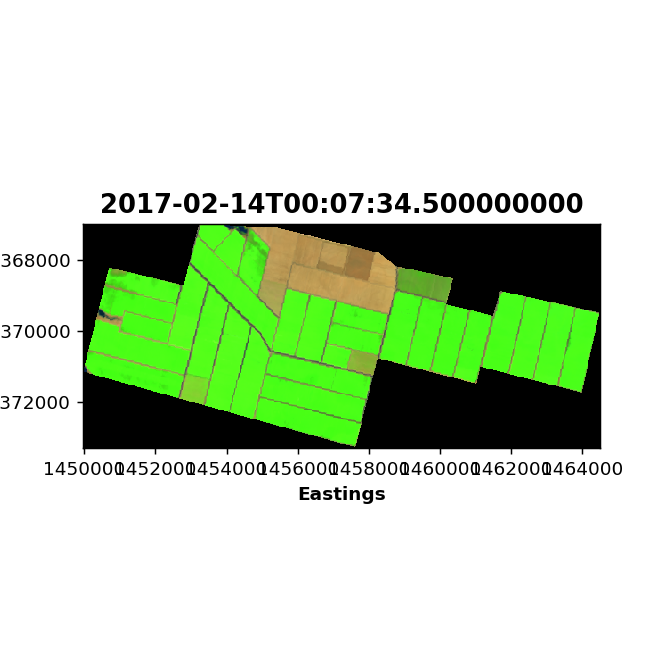

In [35]:
DEAPlotting.three_band_image(Alldata['ls8'], bands = ['swir1', 'nir', 'green'], time = 15, figsize = [5, 5]);

In [26]:
for Sensor in AllSensors:
    try:
        Alldata[Sensor]['NDVI'] = BandIndices.calculate_indices(Alldata[Sensor], 'NDVI')
    except KeyError:
        continue

The formula we are using is (nir - red)/(nir + red)
The formula we are using is (nir - red)/(nir + red)


## Combine all the sensors into a single array

In [29]:
import xarray as xr

Allvalues = xr.concat([Alldata['ls8'].NDVI, 
                       Alldata['s2a'].NDVI], dim = 'time')
Allvalues = Allvalues.sortby('time')

<IPython.core.display.Javascript object>


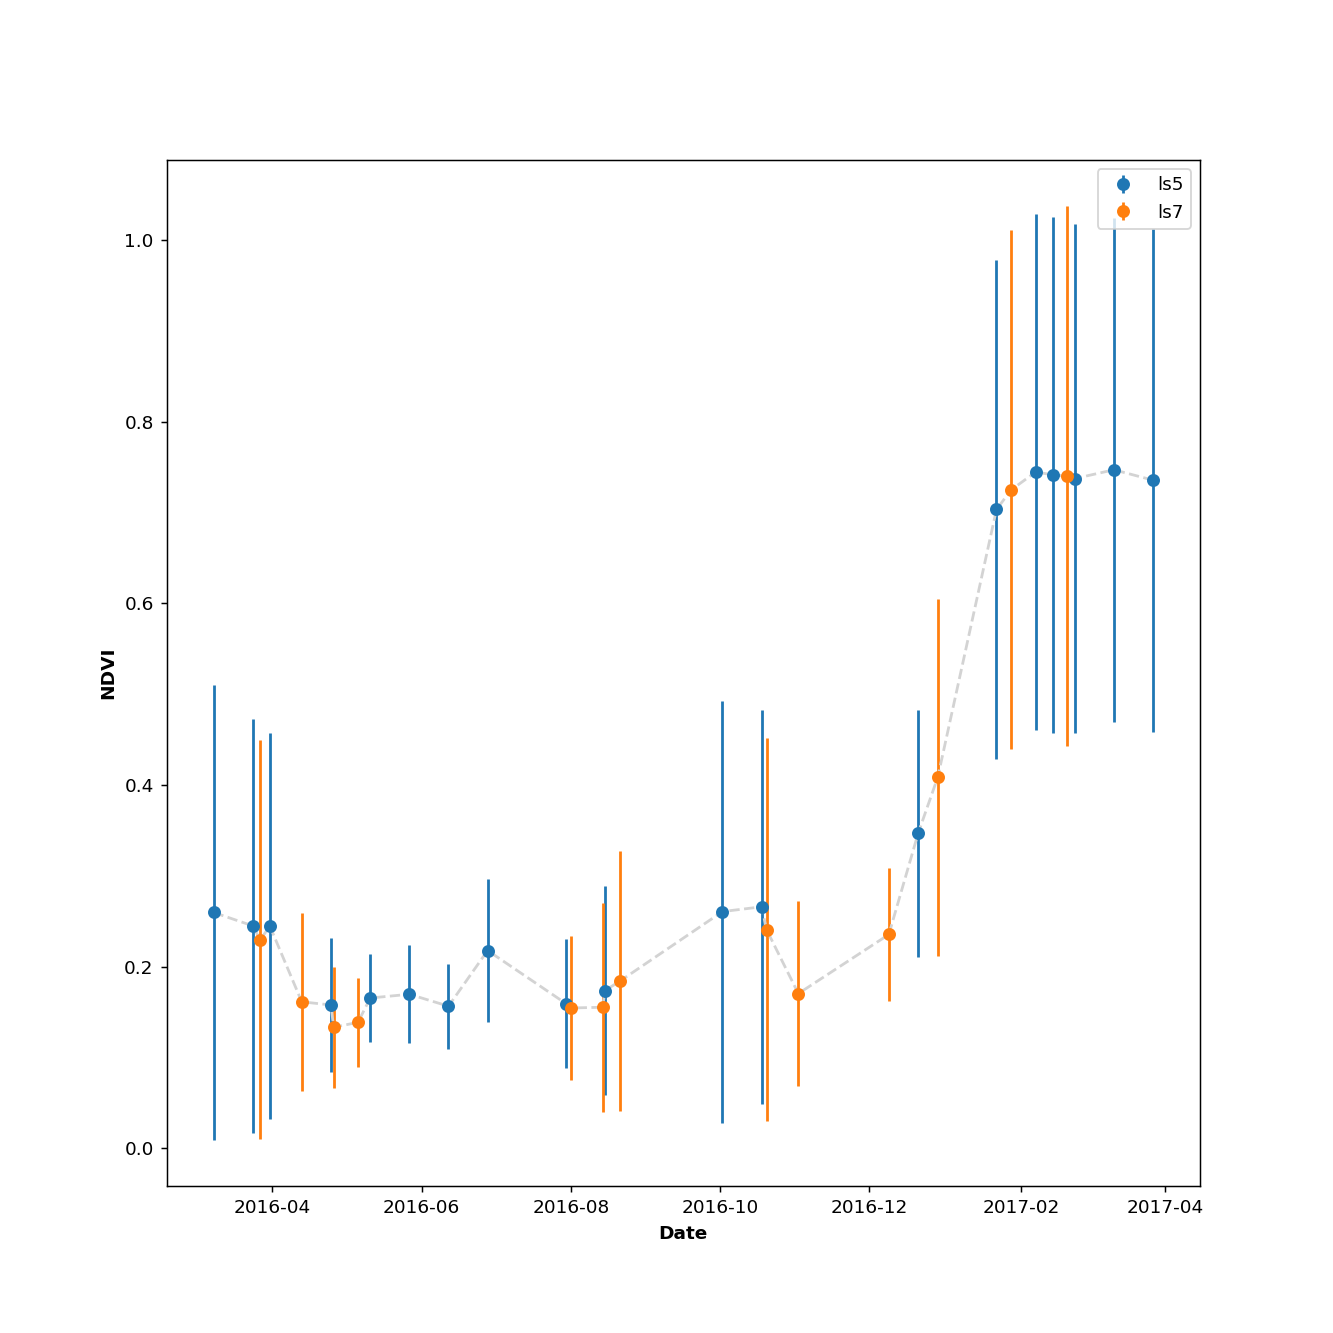

Text(0,0.5,'NDVI')

In [31]:
fig = plt.figure(figsize = [10, 10])
for Sensor in AllSensors:
    try:
        plt.errorbar(Alldata[Sensor].time.values, Alldata[Sensor].NDVI.mean(dim = ('x', 'y')), 
                 Alldata[Sensor].NDVI.std(dim = ('x', 'y')), linestyle='none', marker='o')
    except KeyError:
        continue
        
## Fix legend!!
plt.legend(AllSensors)
plt.plot(Allvalues.time, Allvalues.mean(dim = ('x', 'y')), 'lightgrey', linestyle = '--')
plt.xlabel('Date', fontweight = 'bold')
plt.ylabel('NDVI', fontweight = 'bold')

## Now export our results to CSV

In [33]:
import csv
import os

column_titles = ['Time', 'Mean NDVI', 'Std NDVI', 'Sensor']
output_csv = '/g/data/r78/cek156/dea-notebooks/Crop_mapping/NSWFarm.csv'

# Extra check - If our output exists before starting this loop, let's delete it, just to be safe...
try:
    os.remove(output_csv)
except OSError:
    pass
    
for Sensor in AllSensors:
    try:
        for ix, times in enumerate(Alldata[Sensor].time.values):
            rows = [times, 
                    Alldata[Sensor].isel(time = ix).NDVI.mean(dim = ('x', 'y')).values, 
                    Alldata[Sensor].isel(time = ix).NDVI.std(dim = ('x', 'y')).values, 
                    Sensor]
            if os.path.isfile(output_csv):
                with open(output_csv, 'a') as csvFile:
                    writer = csv.writer(csvFile)
                    writer.writerow(rows)
            else:
                with open(output_csv, 'w') as csvFile:
                    writer = csv.writer(csvFile)
                    writer.writerow(column_titles)
                    writer.writerow(rows)
    except KeyError:
        continue